In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

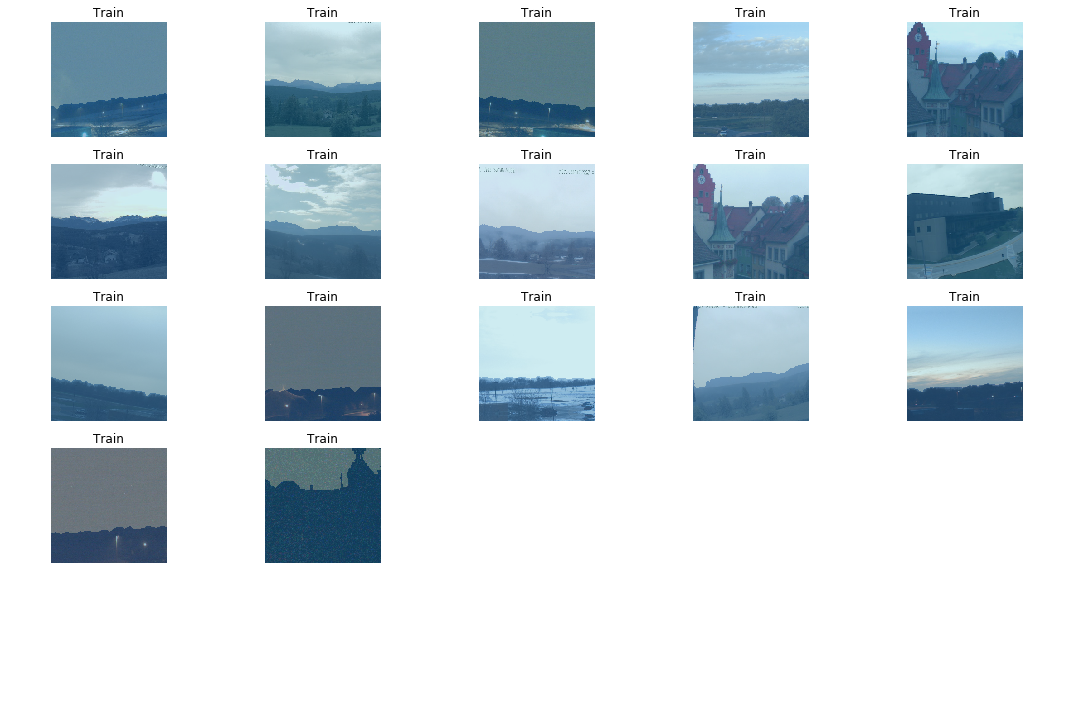

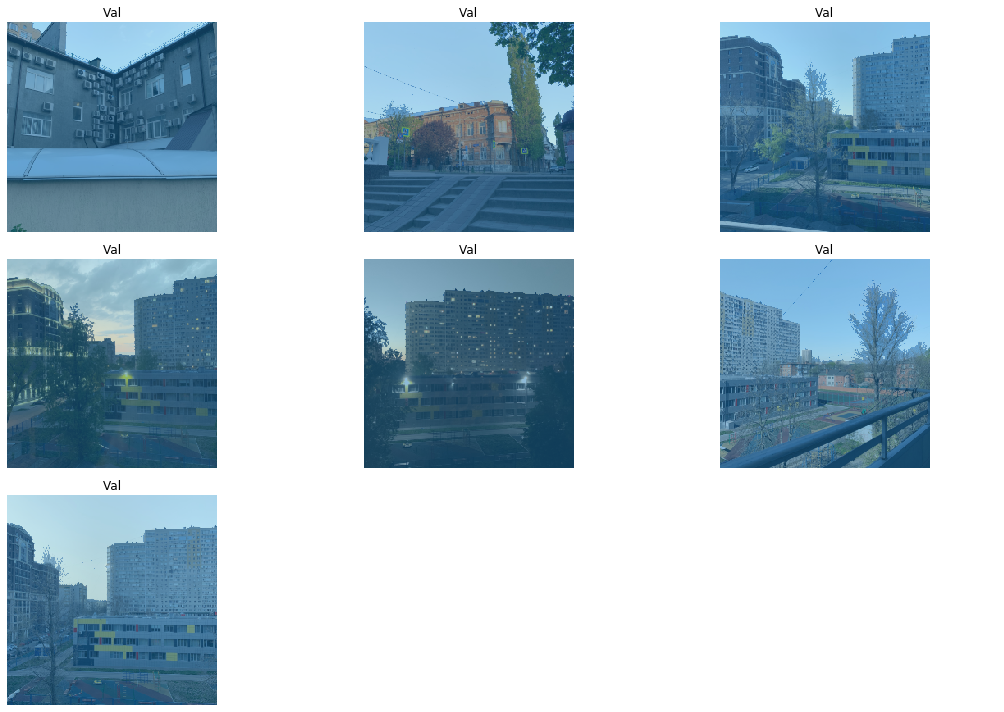

In [2]:
sizes = 256

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train_skyFinder", "test_iphoneXR_v")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=17)
    .normalize(imagenet_stats)
)
classes = train_data.c
train_data.valid_dl.batch_size = 7

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [3]:
model = LinkNet34(num_classes=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCELoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

In [7]:
learner.model.finalconv2

AttributeError: 'Conv2d' object has no attribute 'summary'

In [4]:
# learner.lr_find()
# learner.recorder.plot(suggestion=True, show_grid=True)

In [4]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_const_full_s256_mlr5e03_e25_bs17_without_logit_without_bn")

In [5]:
# learner.fit_one_cycle(100, max_lr=5e-03, callbacks=[tb_callback(learner)])
learner.fit(25, lr=5e-03, callbacks=[tb_callback(learner)])
# learner.fit(10)
# learner.fit_one_cycle(10, max_lr=2e-01)
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.122532,0.134011,0.938161,77.297717,92.166722,02:14
1,0.091184,0.272022,0.910945,70.840025,88.635978,02:14
2,0.076903,0.134648,0.941764,78.572345,92.595097,02:14
3,0.066937,0.117283,0.948388,80.804559,93.406241,02:14
4,0.067373,0.133776,0.947754,79.245610,93.473407,02:15
5,0.056139,0.124058,0.954740,82.510803,94.245224,02:16


profiler execution failed


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dmitri/anaconda3/envs/DiplomaEnv/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._i

KeyboardInterrupt: 

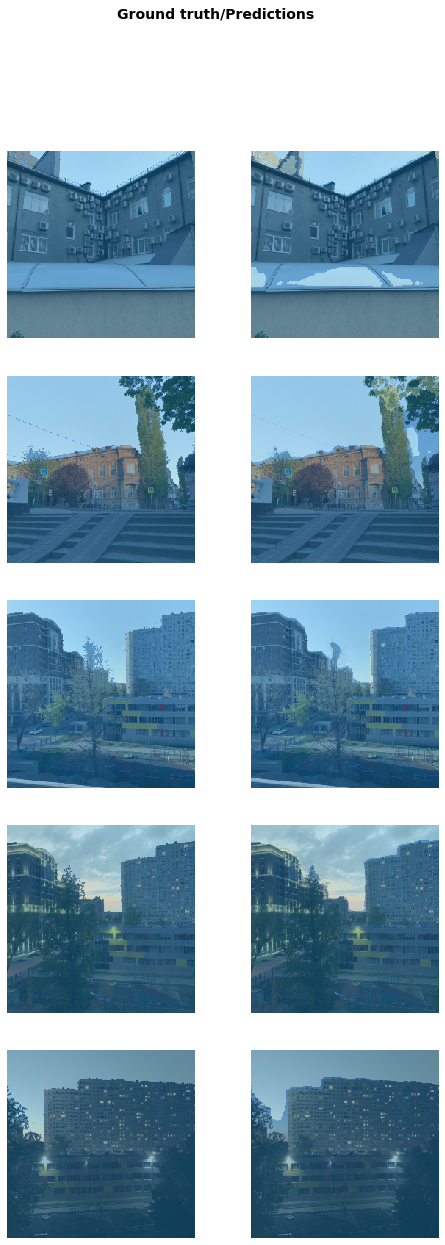

In [6]:
learner.show_results()

In [7]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_const_full_e25_wghts_without_logit")
learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_const_full_e25_exp_without_logit_without_bn")